<a href="https://colab.research.google.com/github/Ruchi-Gohil/Video-Games/blob/master/HousePrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [34]:
pip install pyramid-arima

In [35]:
pip install plotly

In [36]:
pip install chart-studio

Installing Libraries

In [37]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight') 

Above is a special style template for matplotlib, highly useful for visualizing time series data

In [38]:
%matplotlib inline
from pylab import rcParams
from plotly import tools
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error

In [39]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

In [40]:
hp =pd.read_csv('HousePrice.csv')

In [41]:
ma = pd.read_csv('MA.csv')

In [42]:
hp.head()

,datesold,postcode,price,propertyType,bedrooms,Year
0,07/02/2007,2607,525000,house,4,2007
1,27/02/2007,2906,290000,house,3,2007
2,07/03/2007,2905,328000,house,3,2007
3,09/03/2007,2905,380000,house,4,2007
4,21/03/2007,2906,310000,house,3,2007


In [43]:
hp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29580 entries, 0 to 29579
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   datesold      29580 non-null  object
 1   postcode      29580 non-null  int64 
 2   price         29580 non-null  int64 
 3   propertyType  29580 non-null  object
 4   bedrooms      29580 non-null  int64 
 5   Year          29580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 1.4+ MB


In [44]:
ma.head()

,saledate,MA,type,bedrooms
0,30 September 2007,441854,house,2
1,31 December 2007,441854,house,2
2,31 March 2008,441854,house,2
3,30 June 2008,441854,house,2
4,30 September 2008,451583,house,2


In [45]:
ma.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 347 entries, 0 to 346
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   saledate  347 non-null    object
 1   MA        347 non-null    int64 
 2   type      347 non-null    object
 3   bedrooms  347 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 11.0+ KB


**EDA & TIME SERIES VISUALISATIONS**

Date Sold

In [46]:
print("Time period from {} to {}".format(hp.datesold.min(), hp.datesold.max()))

Time period from 01/01/2016 to 31/10/2018


In [47]:
print("Time period from {} to {}".format(ma.saledate.min(), ma.saledate.max()))

Time period from 30 June 2007 to 31 March 2019


In [48]:
## Monthly number of house sales between 2007 and 2019

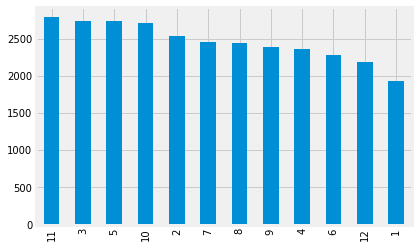

In [49]:
pd.to_datetime(hp.datesold).dt.month.value_counts().plot(kind='bar')

In [50]:
## Yearly number of house sales between 2007 and 2019

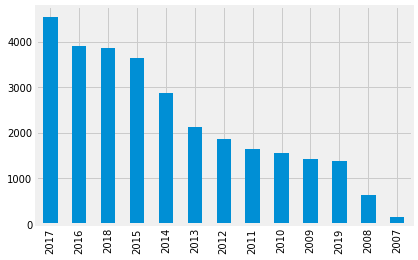

In [51]:
pd.to_datetime(hp.datesold).dt.year.value_counts().plot(kind='bar')

There were a lot of house sales in 2014 - 2017 but all of a sudden dwindled last year (2019). Interesting.

Postcode

In [52]:
bins = pd.IntervalIndex.from_tuples([(2600, 2700), (2701, 2800), (2801, 2915)])
hp['postcode_bin'] = pd.cut(hp['postcode'],bins)

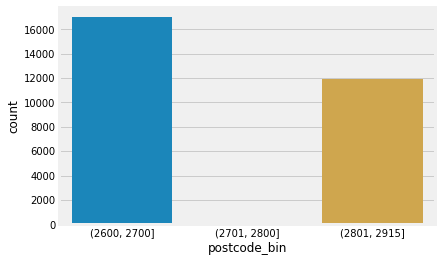

In [53]:
sns.countplot(hp['postcode_bin'])

Interesting to see that there were no house sales for postcodes in between 2700 and 2800. We need more context and knowledge to fully interpret this phenomenon but this could possibly point to the fact that certain regions barely had any house sales while other regions had more active house sales? (discrepancy in house sale numbers across different regions in the U.S.)

PropertyType

In [54]:
hp.propertyType.value_counts()

house    24552
unit      5028
Name: propertyType, dtype: int64

(-1.1062735784564333,
 1.1060571843127553,
 -1.1058990226661722,
 1.1039583716883157)

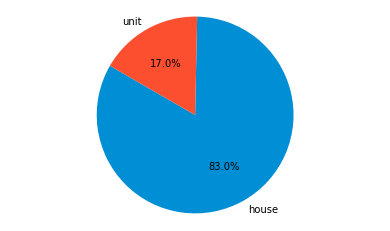

In [55]:
plt.pie(hp['propertyType'].value_counts(), labels=['house','unit'], autopct='%1.1f%%', startangle = 150)
plt.axis('equal')

In [60]:
hp['datesold']= pd.to_datetime(hp['datesold'])

In [61]:
from pandas import Interval

# House sales in postcode 2600 - 2700
hp1 = hp[hp.postcode_bin == Interval(2600, 2700, closed='right')]

# House sales in postcode 2801-2915
hp2 = hp[hp.postcode_bin == Interval(2801, 2915, closed='right')]

Text(0, 0.5, 'Average Price')

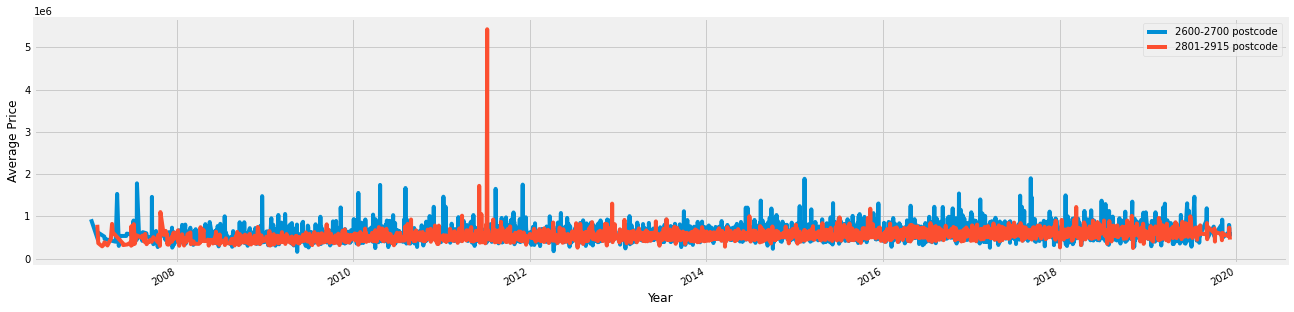

In [62]:
# Average sale price of houses for each of the two postcode bins
rcParams['figure.figsize'] = 20,5 
hp1.groupby('datesold').price.mean().plot()
hp2.groupby('datesold').price.mean().plot()
plt.legend(['2600-2700 postcode', '2801-2915 postcode'])
plt.xlabel("Year")
plt.ylabel("Average Price")

Some unusually high average sale price of houses detected in mid to late 2011 for houses with 2801-2915 postcodes

Prices by PropertyType

In [63]:
hp_house = hp[hp.propertyType == 'house'] 
hp_unit = hp[hp.propertyType == 'unit']

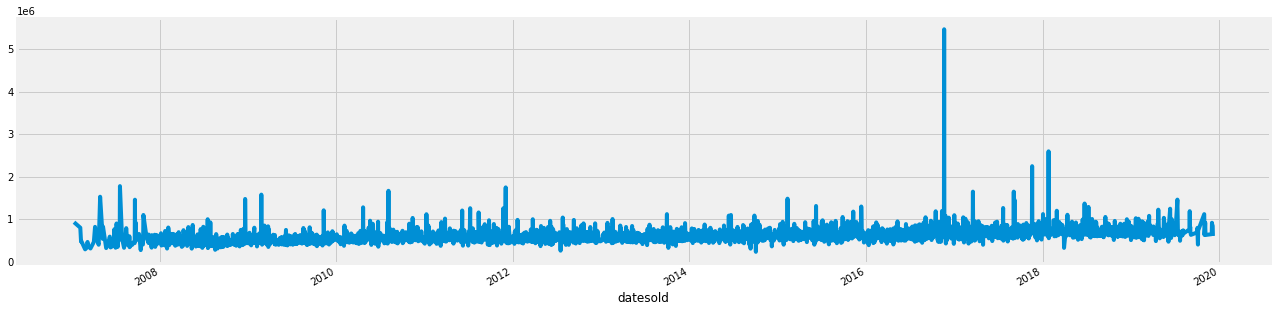

In [64]:
# Average Sale price of house property type over years
hp_house.groupby(['datesold']).price.mean().plot()

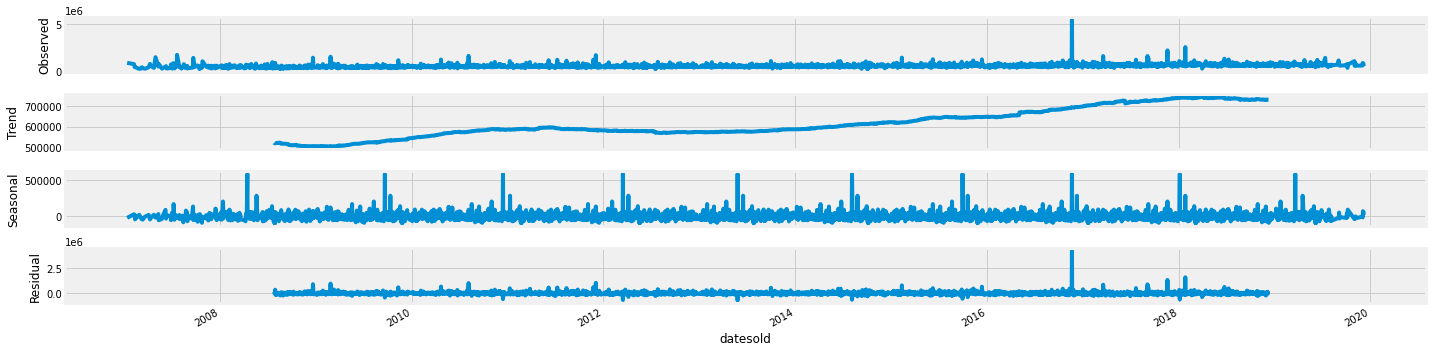

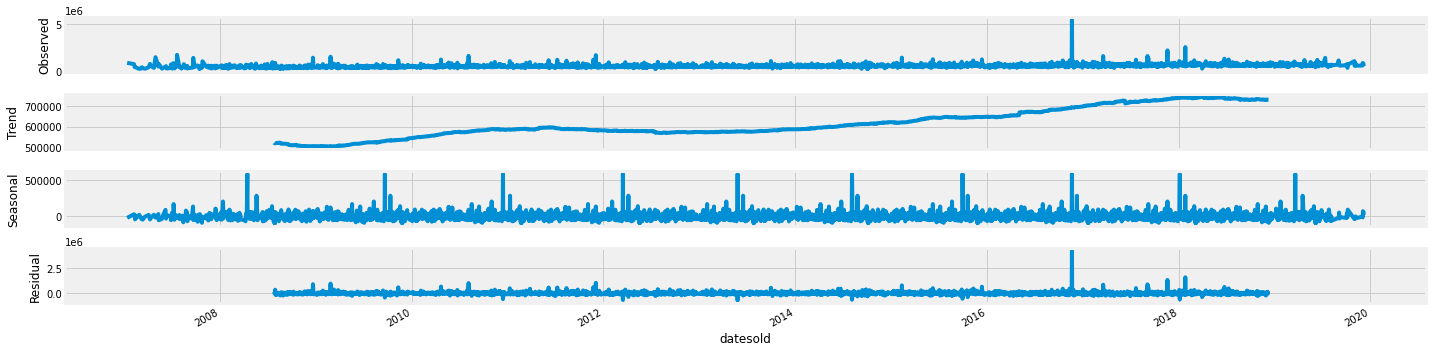

In [65]:
sm.tsa.seasonal_decompose(hp_house.groupby('datesold').price.mean(), freq=365).plot()

Yearly house sale price variation over time for all house sales

In [75]:
hp['datesold_year'] = pd.to_datetime(hp['datesold'])

We saw earlier that the number of houses sold was the highest in the past few years (2016-2019) and we see here that the overall distribution of house sale prices is slightly skewed to the left (with more concentrations on higher prices) with more expensive house sales spotted as outliers (although the distribution of house sale prices looks pretty similar over time with gradual upward movements of boxplots)

In [77]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

Working on Moving Averages File

In [78]:
nRowsRead = 1000 # specify 'None' if want to read whole file
ma1 = pd.read_csv('MA.csv', delimiter=',', nrows = nRowsRead)
ma1.dataframeName = 'MA.csv'
nRow, nCol = ma1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 347 rows and 4 columns


In [81]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

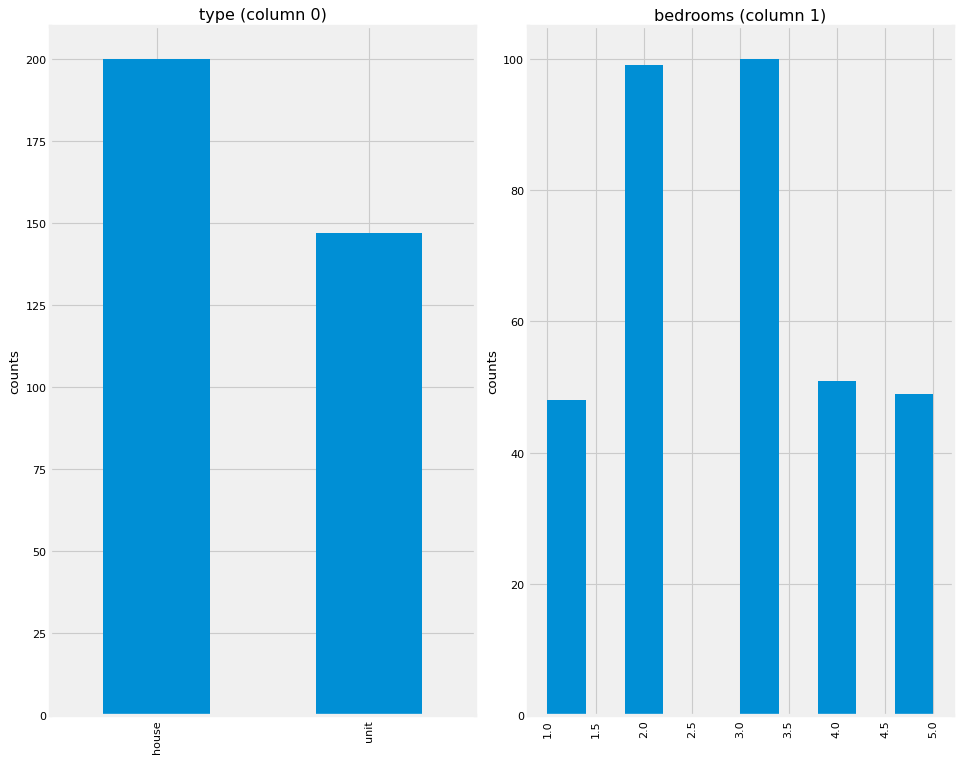

In [82]:
plotPerColumnDistribution(ma1, 10, 5)

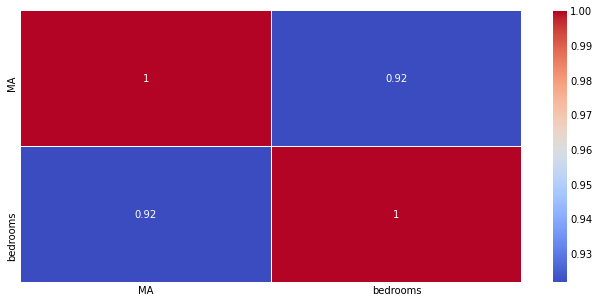

In [84]:
plt.figure(figsize=(10,5))
sns.heatmap(ma.corr(),annot=True,linewidth = 0.5, cmap='coolwarm')

In [97]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for House Price', fontsize=15)
    plt.show()

In [98]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

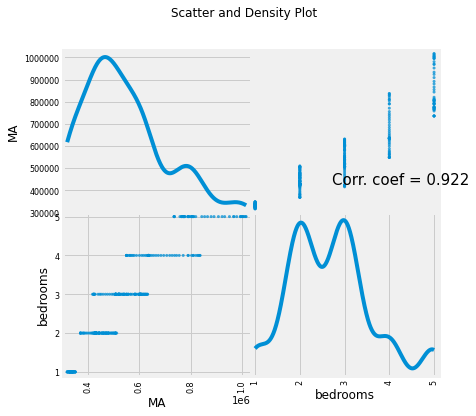

In [99]:
plotScatterMatrix(ma1, 6, 15)

In [100]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# raw_sales.csv has 29580 rows in reality, but we are only loading/previewing the first 1000 rows
hp1 = pd.read_csv('HousePrice.csv', delimiter=',', nrows = nRowsRead)
hp1.dataframeName = 'raw_sales.csv'
nRow, nCol = hp1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 6 columns


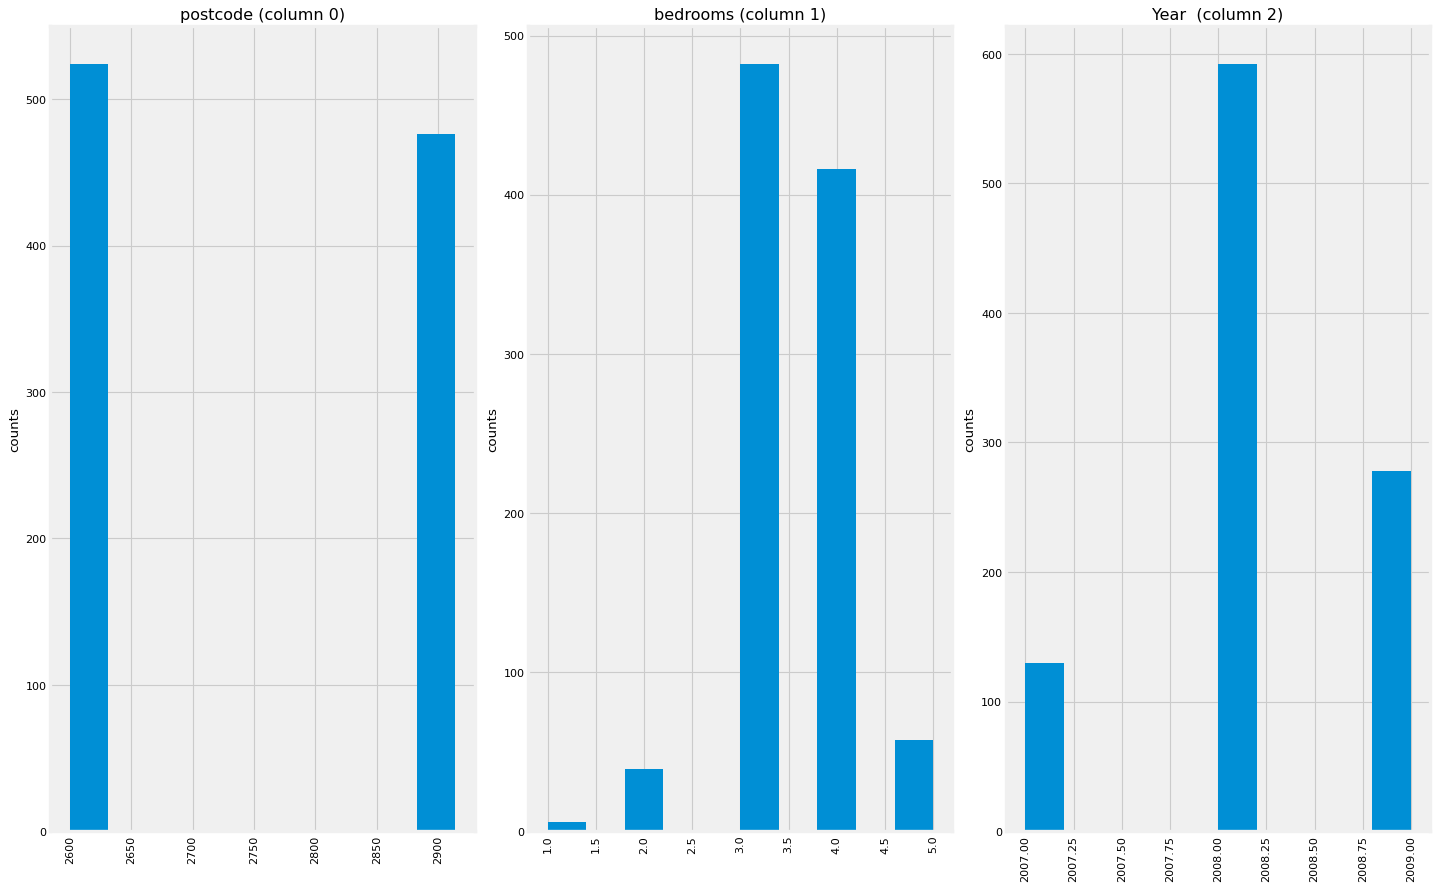

In [101]:
plotPerColumnDistribution(hp1, 10, 5)

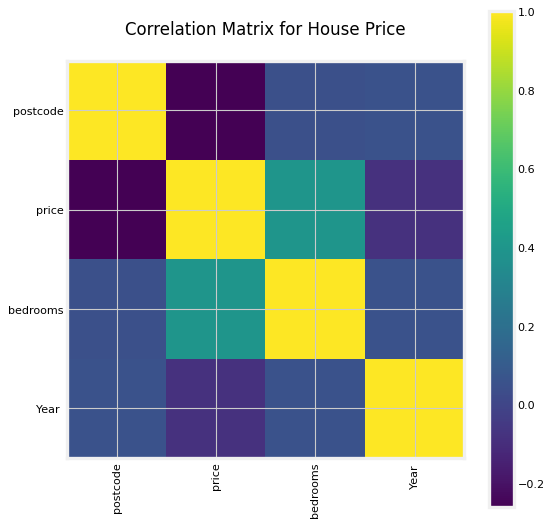

In [102]:
plotCorrelationMatrix(hp1, 8)

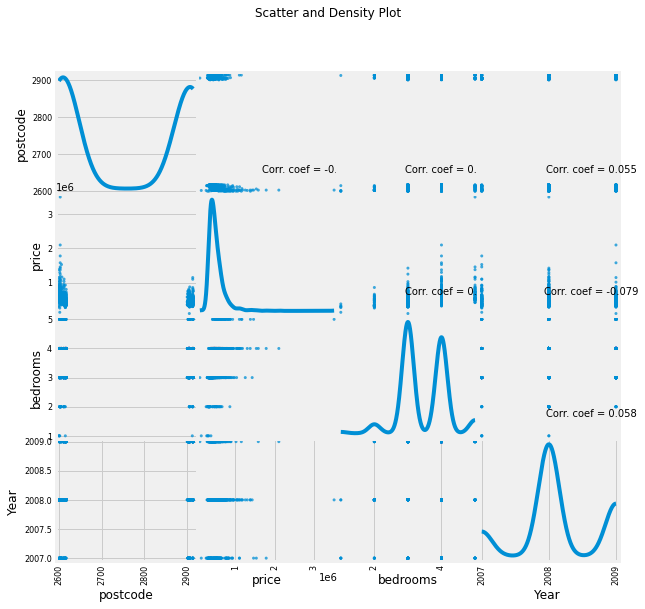

In [96]:
plotScatterMatrix(hp1, 9, 10)

In [103]:
pip install sklearn

In [104]:
hp

,datesold,postcode,price,propertyType,bedrooms,Year,postcode_bin,datesold_year
0,2007,2607,525000,house,4,2007,"(2600, 2700]",1970-01-01 00:00:00.000002007
1,2007,2906,290000,house,3,2007,"(2801, 2915]",1970-01-01 00:00:00.000002007
2,2007,2905,328000,house,3,2007,"(2801, 2915]",1970-01-01 00:00:00.000002007
3,2007,2905,380000,house,4,2007,"(2801, 2915]",1970-01-01 00:00:00.000002007
4,2007,2906,310000,house,3,2007,"(2801, 2915]",1970-01-01 00:00:00.000002007
...,...,...,...,...,...,...,...,...
29575,2019,2900,500000,unit,3,2019,"(2801, 2915]",1970-01-01 00:00:00.000002019
29576,2019,2612,560000,unit,2,2019,"(2600, 2700]",1970-01-01 00:00:00.000002019
29577,2019,2912,464950,unit,2,2019,"(2801, 2915]",1970-01-01 00:00:00.000002019
29578,2019,2601,589000,unit,2,2019,"(2600, 2700]",1970-01-01 00:00:00.000002019


In [105]:
ma

,saledate,MA,type,bedrooms
0,30 September 2007,441854,house,2
1,31 December 2007,441854,house,2
2,31 March 2008,441854,house,2
3,30 June 2008,441854,house,2
4,30 September 2008,451583,house,2
...,...,...,...,...
342,30 September 2018,603281,unit,3
343,31 December 2018,601167,unit,3
344,31 March 2019,605637,unit,3
345,30 June 2019,599339,unit,3


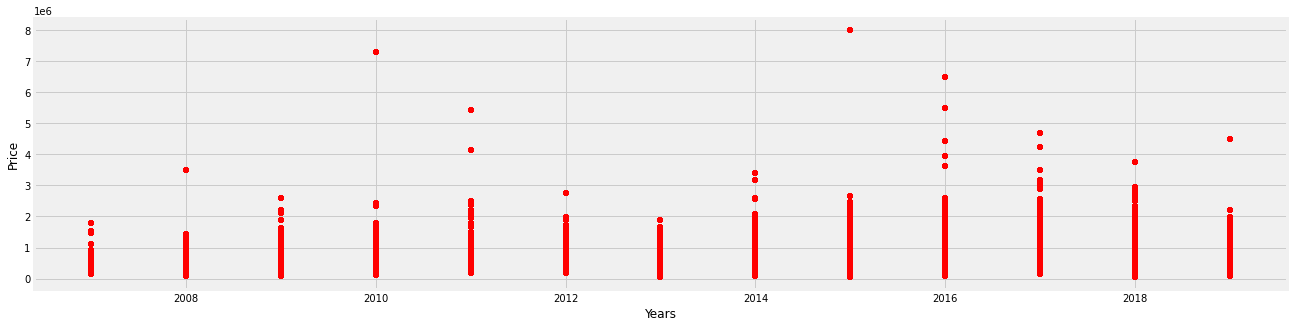

In [106]:
plt.xlabel('Years')
plt.ylabel('Price')
plt.scatter(hp.datesold,hp.price,color='red',marker='+')

In [107]:
ps= hp.price

In [113]:
X = hp[['postcode','bedrooms']]
Y = hp['price']

In [114]:
from sklearn import linear_model

In [115]:
regr = linear_model.LinearRegression()
regr.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [116]:

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)


Intercept: 
 1519628.8724785228
Coefficients: 
 [  -525.75562731 161699.75889029]


In [118]:
NewPostcode = 2607
Newbedrooms = 4
print ('Predicted Price: \n', regr.predict([[NewPostcode,Newbedrooms]]))

Predicted Price: 
 [795782.98762983]


In [119]:
X = sm.add_constant(X)

In [120]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [121]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.306
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     6509.
Date:                Sun, 12 Jul 2020   Prob (F-statistic):               0.00
Time:                        08:51:47   Log-Likelihood:            -4.0777e+05
No. Observations:               29580   AIC:                         8.155e+05
Df Residuals:                   29577   BIC:                         8.156e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.52e+06   2.55e+04     59.685      0.0

**Time** **Series** **Analysis**

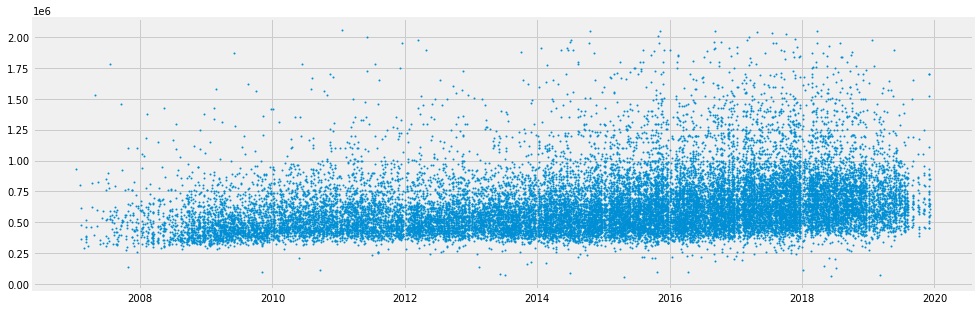

In [123]:
# We will clean, explore and visualise the raw data first
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
hp=pd.read_csv('HousePrice.csv')
hp=hp[hp.propertyType=='house'] #Let's limit the scope of this problem to houses only
hp['datesold'] = pd.to_datetime(hp['datesold'])
hp=hp.drop(columns=['postcode', 'propertyType'])
hp = hp[np.abs(hp.price - hp.price.mean()) <= (5.0 * hp.price.std())] # Clean the outliers
%matplotlib inline 
plt.figure(figsize=(15,5))
plt.plot_date(hp['datesold'], hp['price'], xdate=True, markersize=1)

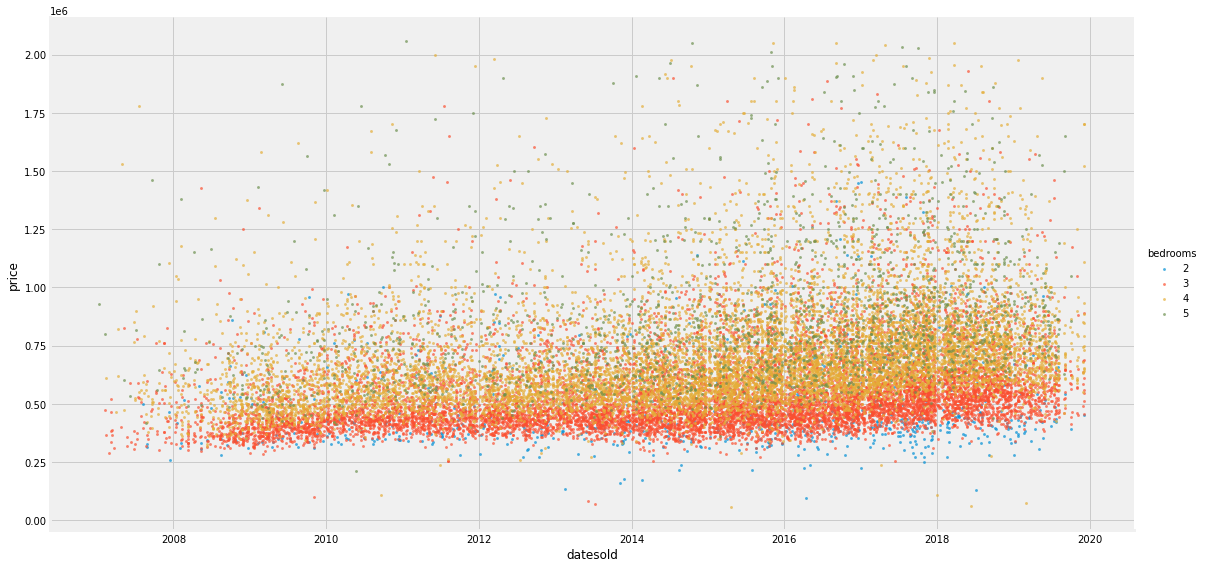

In [126]:
# We will group and visualise the data by the number of bedrooms
import seaborn
from  matplotlib import pyplot
hp=hp[hp.bedrooms>1] # 0 and 1 bedrooms are not relevant to houses and should be discarded
_bedrooms=hp['bedrooms'].unique().sort()
fg = seaborn.FacetGrid(data=hp, hue='bedrooms', hue_order=_bedrooms, aspect=2, height=8)
fg.map(pyplot.scatter, 'datesold', 'price', alpha=.7, s=5).add_legend()
#This data may be useful for forecasts via a neural network.

In [127]:
ma=pd.read_csv('MA.csv')
ma=ma[ma.type=='house'] #Let's limit the scope of this problem to houses only
ma['saledate'] = pd.to_datetime(ma['saledate'])
ma.tail()

,saledate,MA,type,bedrooms
195,2018-09-30,1007114,house,5
196,2018-12-31,1002323,house,5
197,2019-03-31,998136,house,5
198,2019-06-30,995363,house,5
199,2019-09-30,970268,house,5


In [128]:
#Pivot the data so we can feed it into the model
ma=ma.pivot(index='saledate', columns='bedrooms', values='MA').interpolate(method='linear', limit_direction='both')
ma.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,504318.0,624602.0,830727.0,1007114.0
2018-12-31,506001.0,626608.0,820924.0,1002323.0
2019-03-31,496133.0,628423.0,811121.0,998136.0
2019-06-30,500158.0,630814.0,803925.0,995363.0
2019-09-30,510712.0,631875.0,791446.0,970268.0


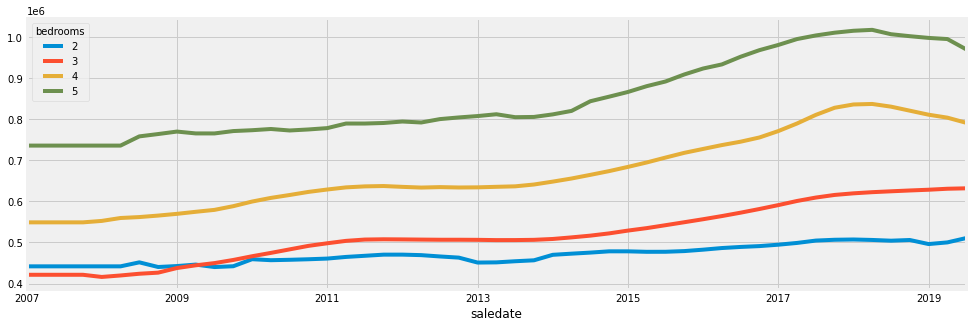

In [130]:
#Plot the data
%matplotlib inline 
ma.plot(figsize=(15,5))
#It is evident that 2 bedroom curve before 2009 is not an accurate representation of the actual median price.
#It is not possible for a 2 bedroom median price to be above that of 3 bedroom median price.
#This is due to low number of sales in that timeframe, which skews the calculated median price.

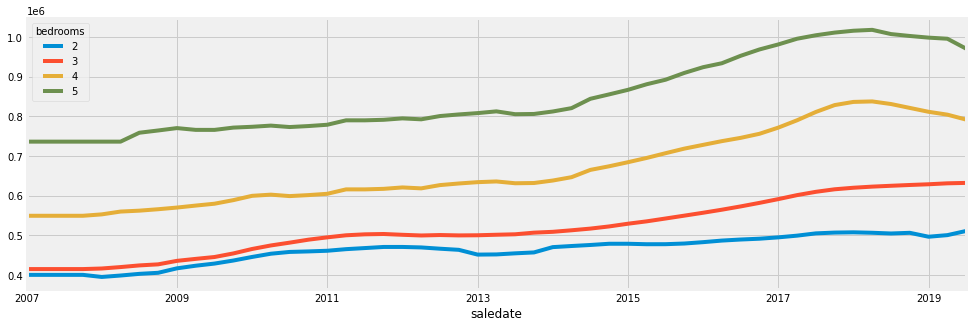

In [131]:
# Let's see what we can do to correct the overlapping lines for 2 and 3 br data
def separate_series(ma):
    columns = list(ma) 
    for col in columns: 
        if col== columns[-1]:
            break
        #Calculate average difference between 2 and 3 bedrooms for the recent  1/3 of the dataframe
        diff_mean= (ma[col+1][:-int(len(ma)/3)]-ma[col][:-int(len(ma)/3)]).mean()
        #Where 2 br price is higher than that of 3 br, replace it with 3 br price minus the diff
        #do_they_intersect = False if df[col].loc[df[col] >= df[col+1], ].empty else True
        #if do_they_intersect:
        ma.loc[ma[col] > ma[col+1]-diff_mean, col] = ma[col+1]-diff_mean
    return ma
ma=separate_series(ma)
ma.plot(figsize=(15,5))

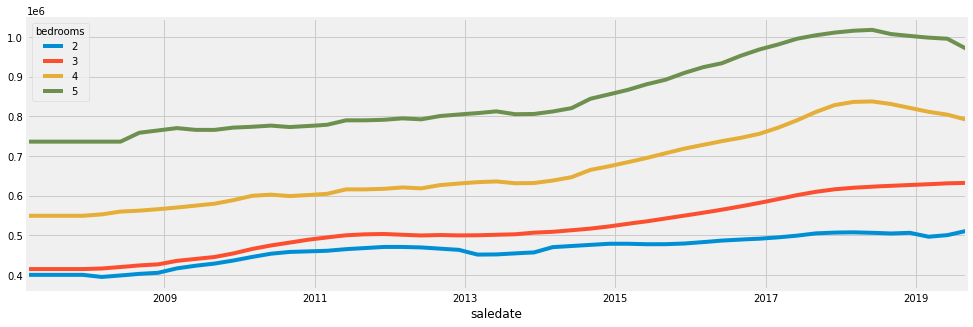

In [132]:
#if you are after monthly frequency we can resample the quarterly data to monthly by
ma_monthly = ma.resample('M').interpolate(method='linear', limit_direction='both').astype(int)
#if you are after weekly or daily just replace 'M' with 'W' or 'D' respectively
ma_monthly.tail()
ma_monthly.plot(figsize=(15,5))

In [133]:
#Coint Johansen test for all # bedrooms columns
from statsmodels.tsa.vector_ar.vecm import coint_johansen
coint_johansen(ma,-1,1).eig

array([0.40292351, 0.16715847, 0.09216369, 0.00183796])

In [134]:
#Split the data into train and test
train = ma[:int(0.9*(len(ma)))]
test = ma[int(0.9*(len(ma))):]

#Fit the model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(endog=train, freq='Q-DEC')
model_fit = model.fit()

#Forecast based on train data
forecast = model_fit.forecast(model_fit.endog, steps=len(test))

In [135]:
#Convert forecast data to a dataframe we can use
cols = ma.columns
pred = pd.DataFrame(index=test.index, data=forecast,columns=[cols])
pred=pred.astype(int)
pred.tail()

bedrooms,2,3,4,5
saledate,,,,
2018-09-30,507480,631399,861752,1045546
2018-12-31,507833,637650,875549,1061382
2019-03-31,508310,644176,890014,1077831
2019-06-30,508891,650995,905172,1094935
2019-09-30,509559,658120,921046,1112734


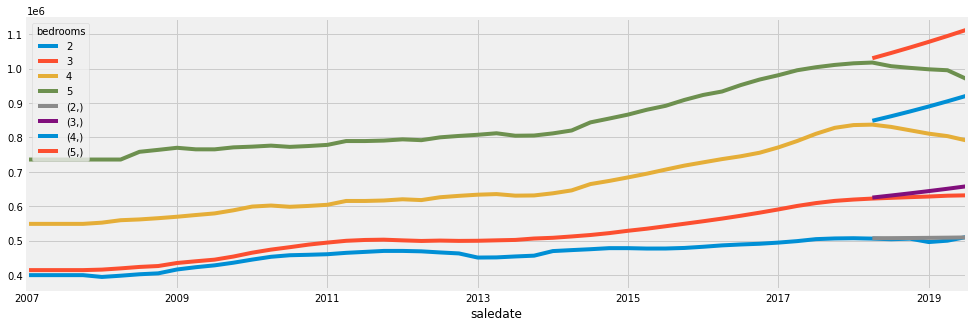

In [136]:
#Plot actuals (ma) and forecast (pred) on the same chart
ax = ma.plot()
pred.plot(ax=ax,figsize=(15,5))

In [137]:
#Show percentage difference between the last period of the forecast and actual series. Less is better.
((pred.iloc[-1].values-pred.iloc[0].values)/ma.iloc[-1].values)*100

array([0.44721878, 5.17760633, 9.15400419, 8.49827058])

In [138]:
#Here is the mean absolute percentage error
import numpy as np
for col in ma.columns:
    print (str(col) +' bedrooms ' + str(np.mean(np.abs((ma[col].iloc[-len(pred):].values - pred[[col]].values) / ma[col].iloc[-len(pred):].values)) * 100))

2 bedrooms 1.027963025803897
3 bedrooms 2.3523955523069557
4 bedrooms 8.347488048618313
5 bedrooms 7.229671356483708


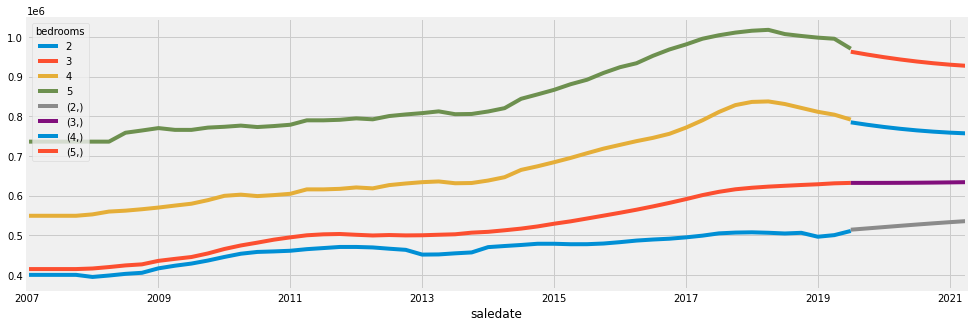

In [146]:
#Forecast actuals
model = VAR(endog=ma, freq='Q-DEC')
model_fit = model.fit()
forecast_period=8
prediction = model_fit.forecast(model_fit.endog, steps=forecast_period)
cols = ma.columns
forecast_index = pd.date_range(start ='2019-09-30', freq ='Q', periods=forecast_period) 
pred = pd.DataFrame(index=forecast_index, data=prediction,columns=[cols])
ax = ma.plot()
pred.plot(ax=ax,figsize=(15,5))